## Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import cufflinks as cf
import folium
import statsmodels.api as sm
from pylab import rcParams
import numpy as np

cf.go_offline()

In [2]:
def set_xticklabels(fg, rotation=0):
    """
    Input: fg --> FacetGrid
           rotation --> Int
    
    # Sets the properties on the xtick labels of a FacetGrid and the space between plots.
    """
    for ax in fg.axes:
        plt.setp(ax.get_xticklabels(), visible=True, rotation=rotation, ha='right')
        
    plt.subplots_adjust(hspace=0.5)

    

### Setting visual parameters of plots

In [3]:
rcParams['figure.figsize'] = 20, 10
plt.style.use('fivethirtyeight')

## Importing dataset

In [4]:
chicago_cmr1 = pd.read_csv('chicago_clean.csv')

In [5]:
chicago_cmr = pd.read_csv('../Data/Crimes_-_2001_to_present.csv')

In [6]:
chicago_cmr1.head()

,Date,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Year,Latitude,Longitude,Location
0,2001-01-01 00:00:00,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,0,0,631,6.0,2001,41.748623,-87.608654,"(41.748623027, -87.608654109)"
1,2001-01-01 00:00:00,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,0,0,624,6.0,2001,41.754802,-87.598147,"(41.754802305, -87.598146873)"
2,2001-01-01 00:00:00,0810,THEFT,OVER $500,APARTMENT,0,0,2332,19.0,2001,41.938952,-87.638164,"(41.938952432, -87.638163582)"
3,2001-01-01 00:00:00,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,0,0,624,6.0,2001,41.752062,-87.607828,"(41.752061911, -87.607827503)"
4,2001-01-01 00:00:00,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,0,0,1013,10.0,2001,41.850386,-87.715108,"(41.850385805, -87.715107802)"


### We're curious about which are the districts with more crimes commited over these years.

In [7]:
crime_district = chicago_cmr1.groupby('District').size().reset_index(name='Crime_Counts').sort_values(by='Crime_Counts', ascending=False)
crime_district.head()

,District,Crime_Counts
7,8.0,457870
10,11.0,429436
6,7.0,397281
5,6.0,387977
22,25.0,387906


### Following our previous exploration, we're going to check for the top 5 types of crime commited in each district. Since we're not sharing the y-axis, we get an overview of the amount of crimes commited in each district too. If we chose to share the y-axis, we would also see the difference in crime counts between districts.

In [8]:
data = chicago_cmr1.groupby(['District', 'Primary Type']).size().reset_index(name='Crime_Counts').groupby('District').apply(lambda x: x.sort_values(by='Crime_Counts', ascending=False).head(5))
type(data)

pandas.core.frame.DataFrame

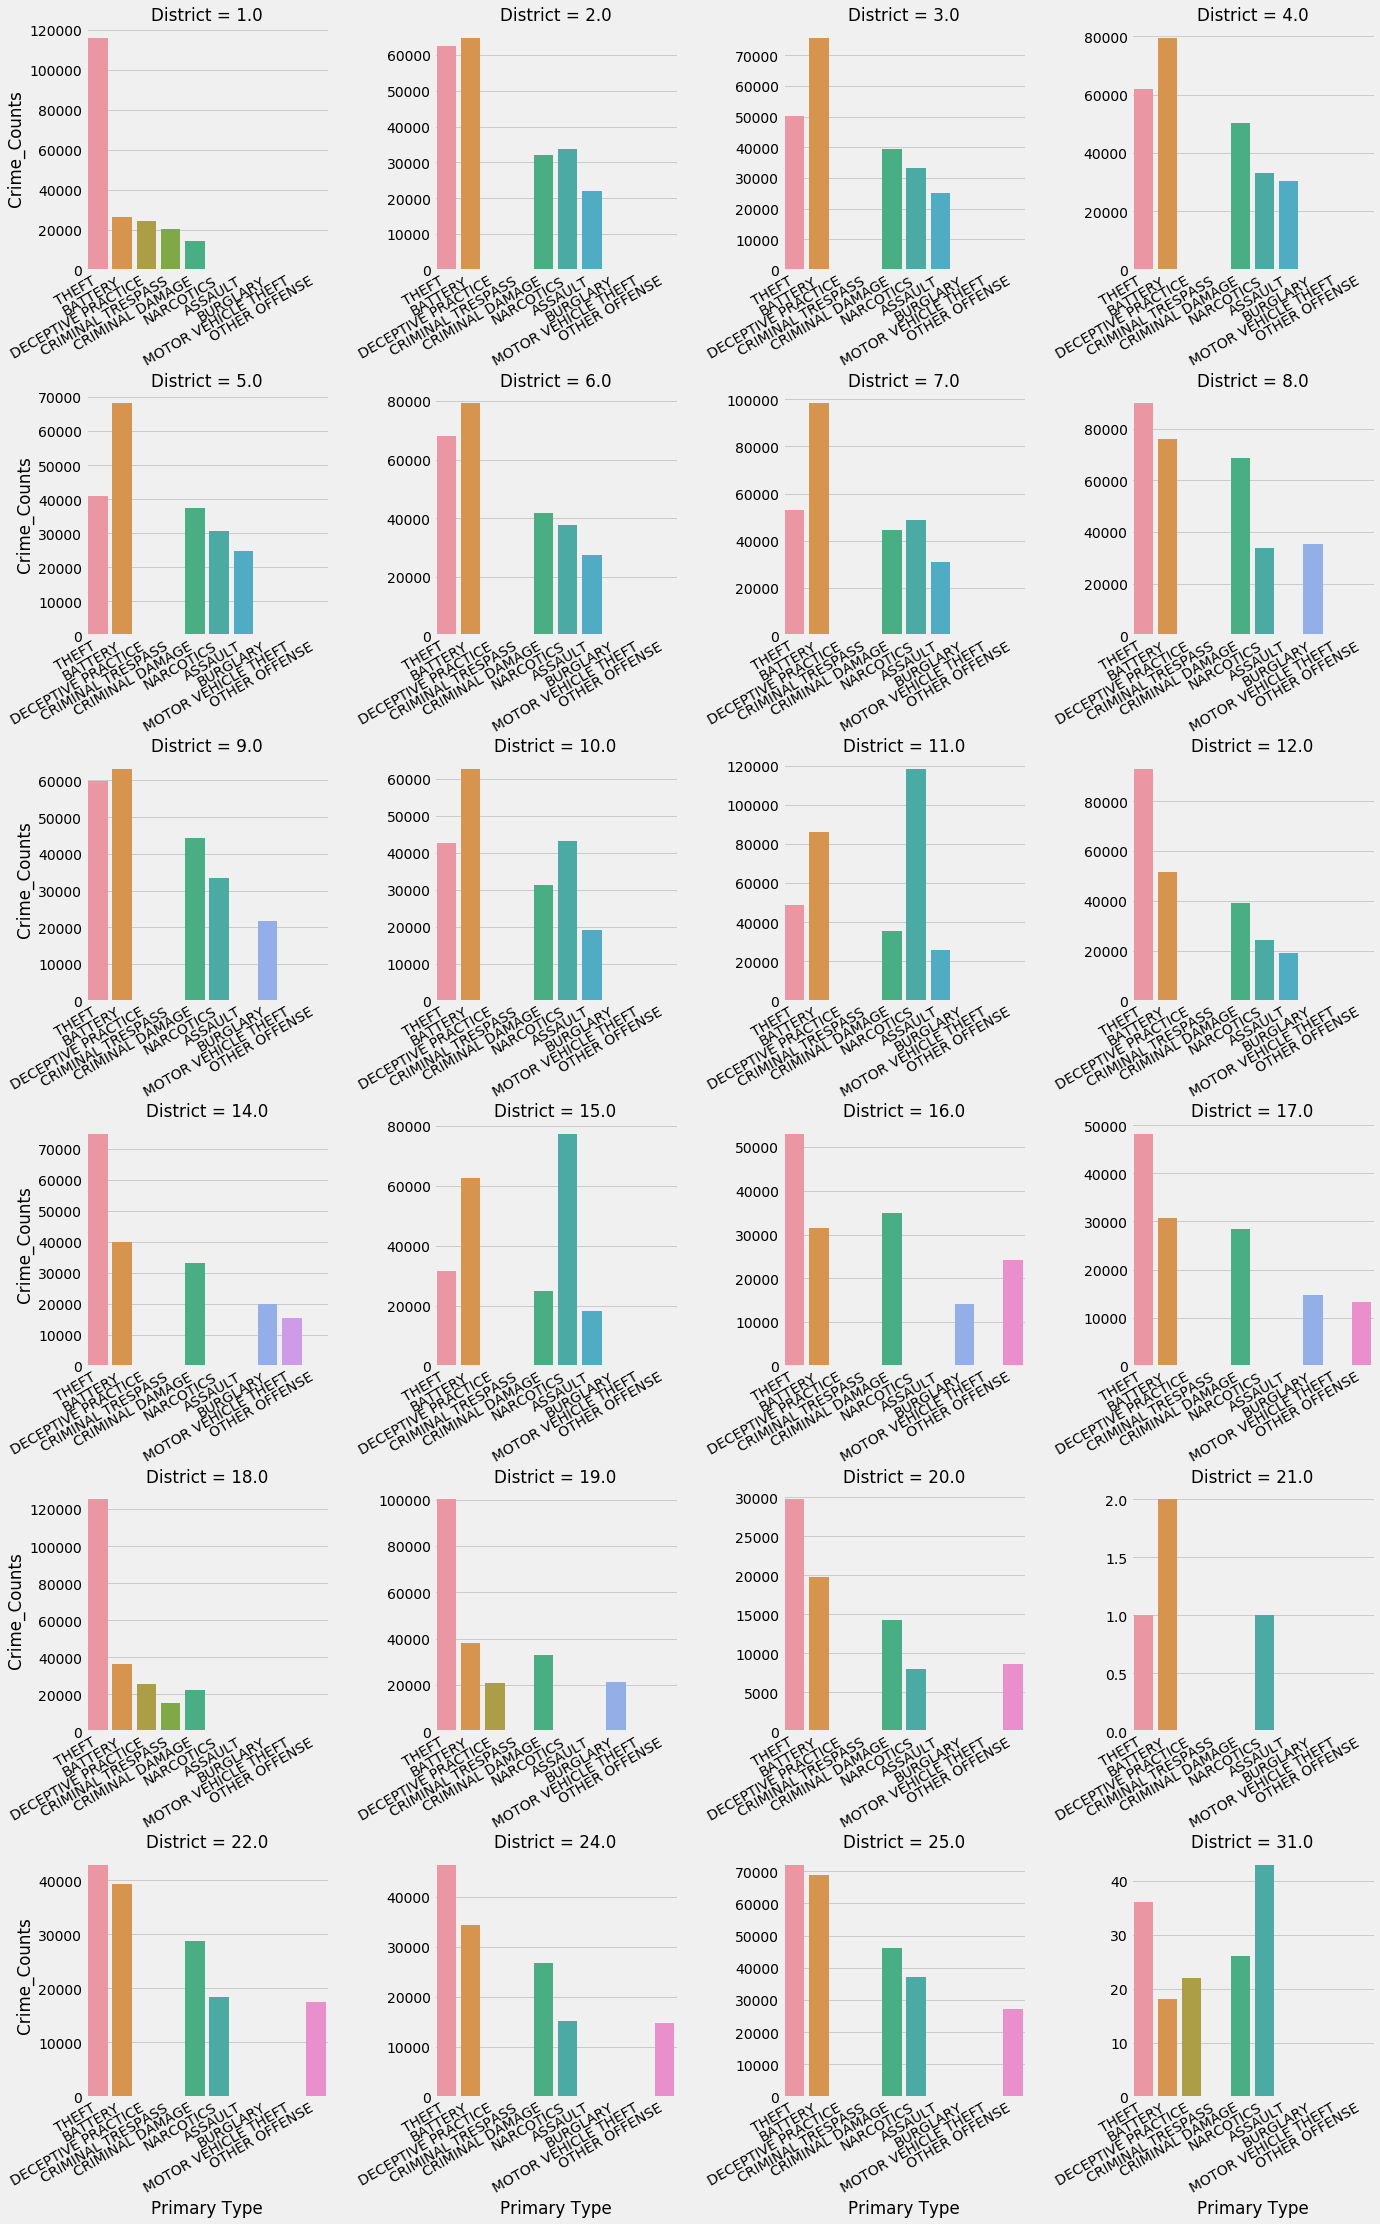

In [9]:
# Plotting top 5 crime types commited per District
crimeT_district = sns.catplot(x='Primary Type', y='Crime_Counts', col='District',
                              data=data, sharey=False, col_wrap=4, kind='bar')

# Setting visual aspects of FacetGrid
set_xticklabels(crimeT_district, 30)


### Now we're going to explore the arrests in each district, also we get the crimes which didn't end up in arrest. We could take the crimes commited and the arrests as a measure of which are the most dangerous districts.

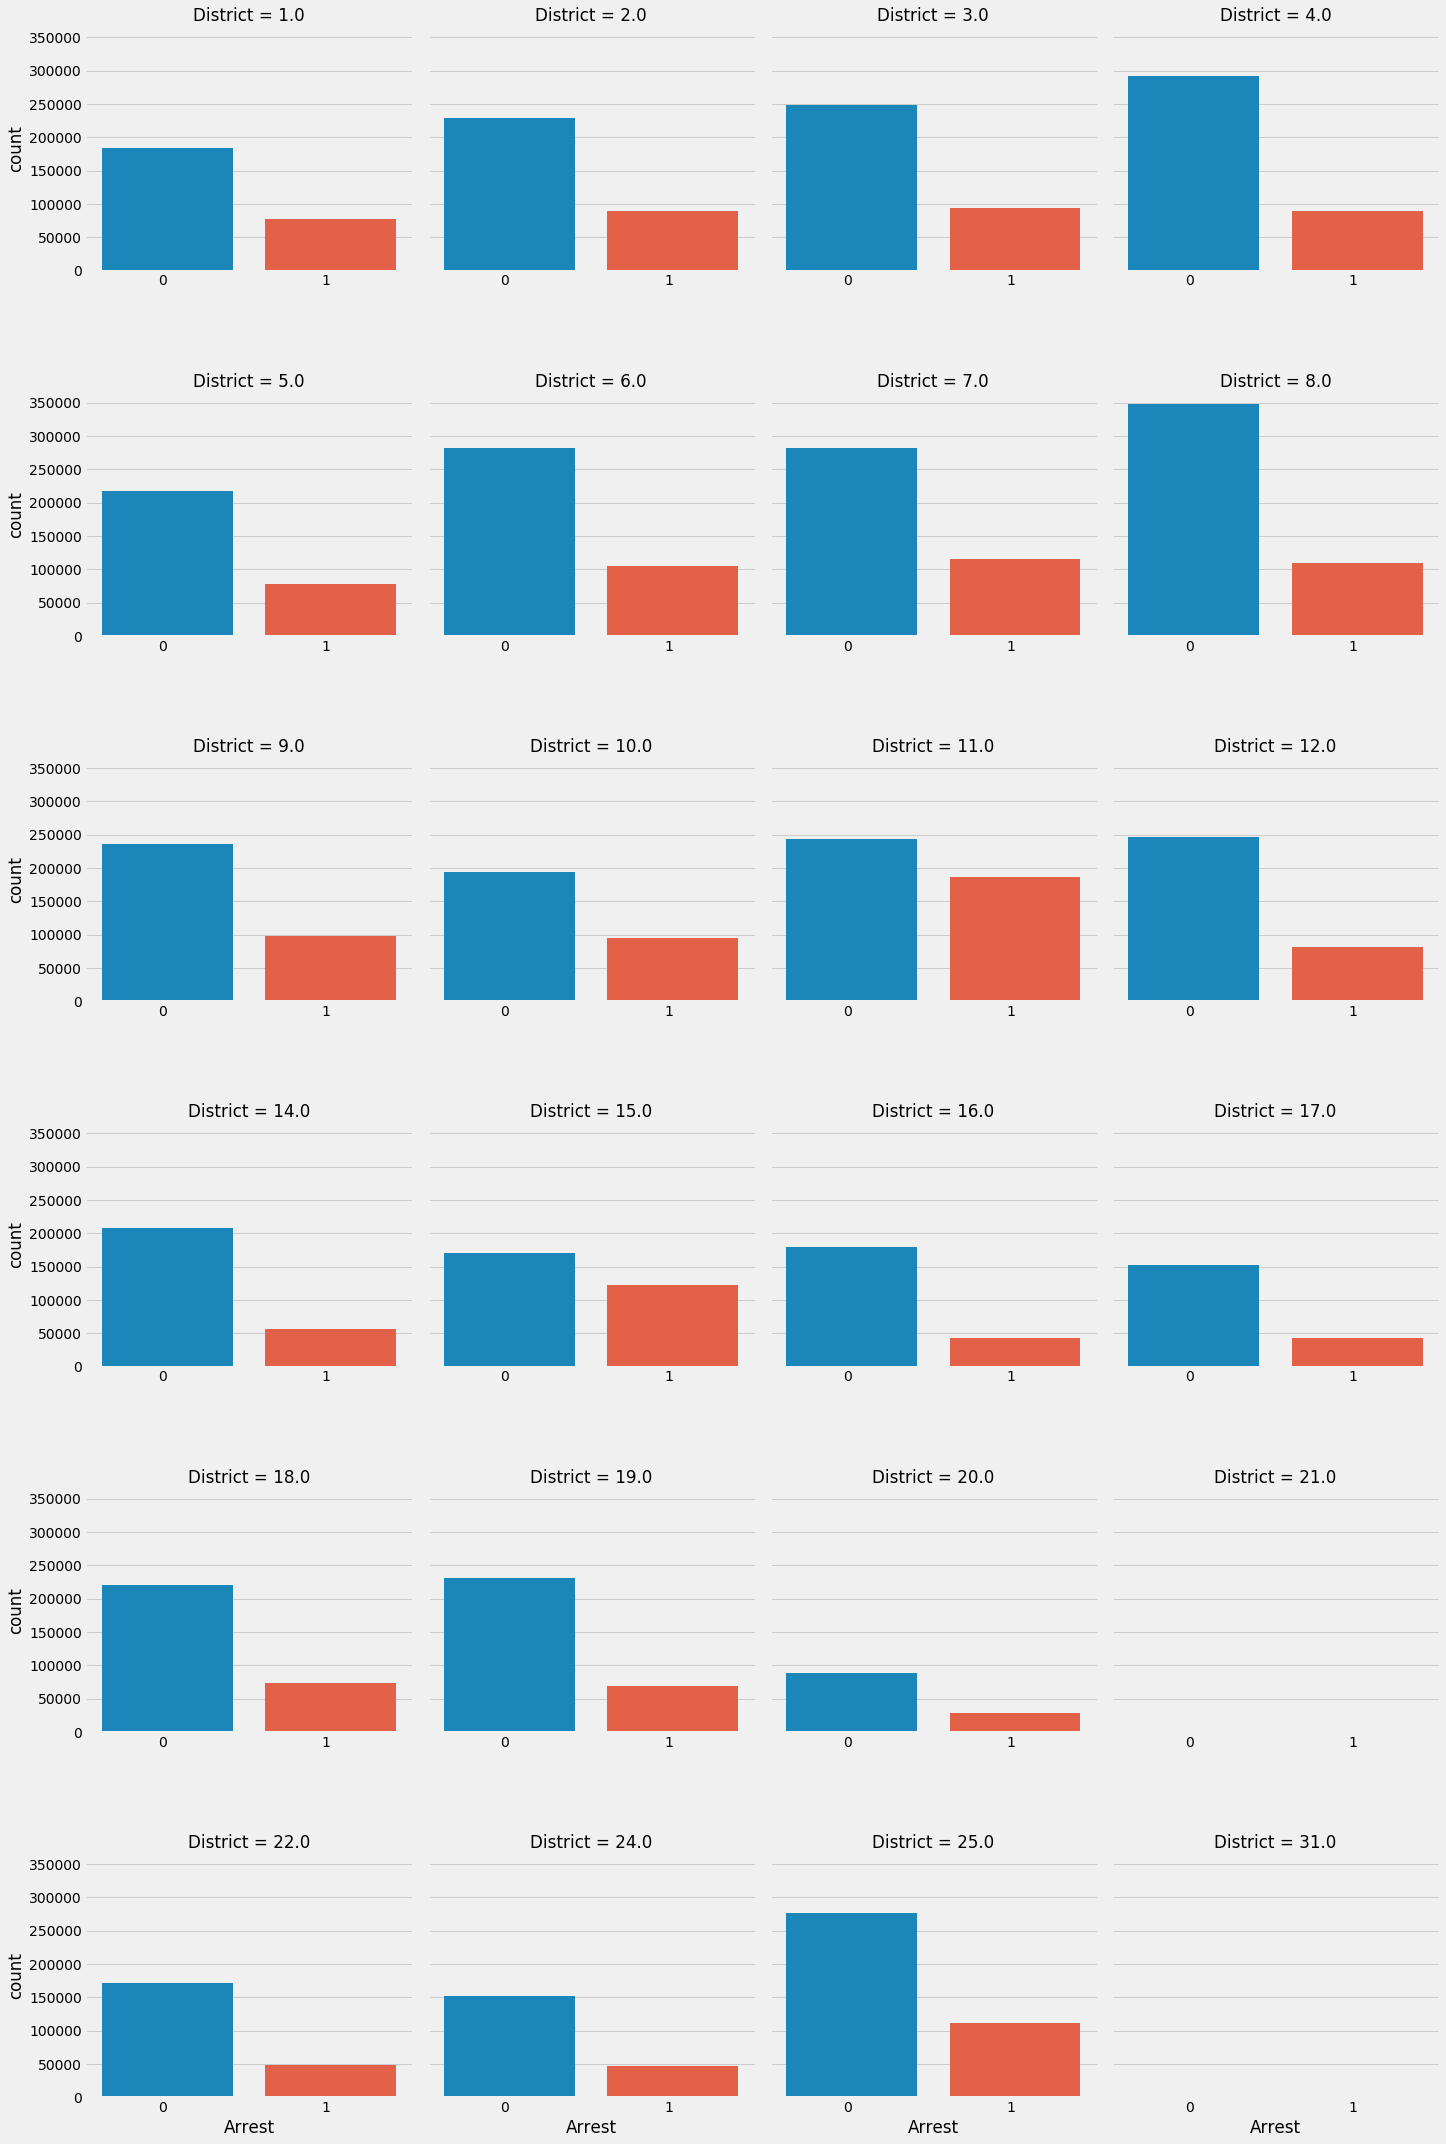

In [10]:
arrest_district = sns.catplot(x="Arrest", col="District", col_wrap=4, data=chicago_cmr1, kind="count")

# Setting visual aspects of FacetGrid
set_xticklabels(arrest_district)

### Now we're going to check which are the most common crime types and the most common location.

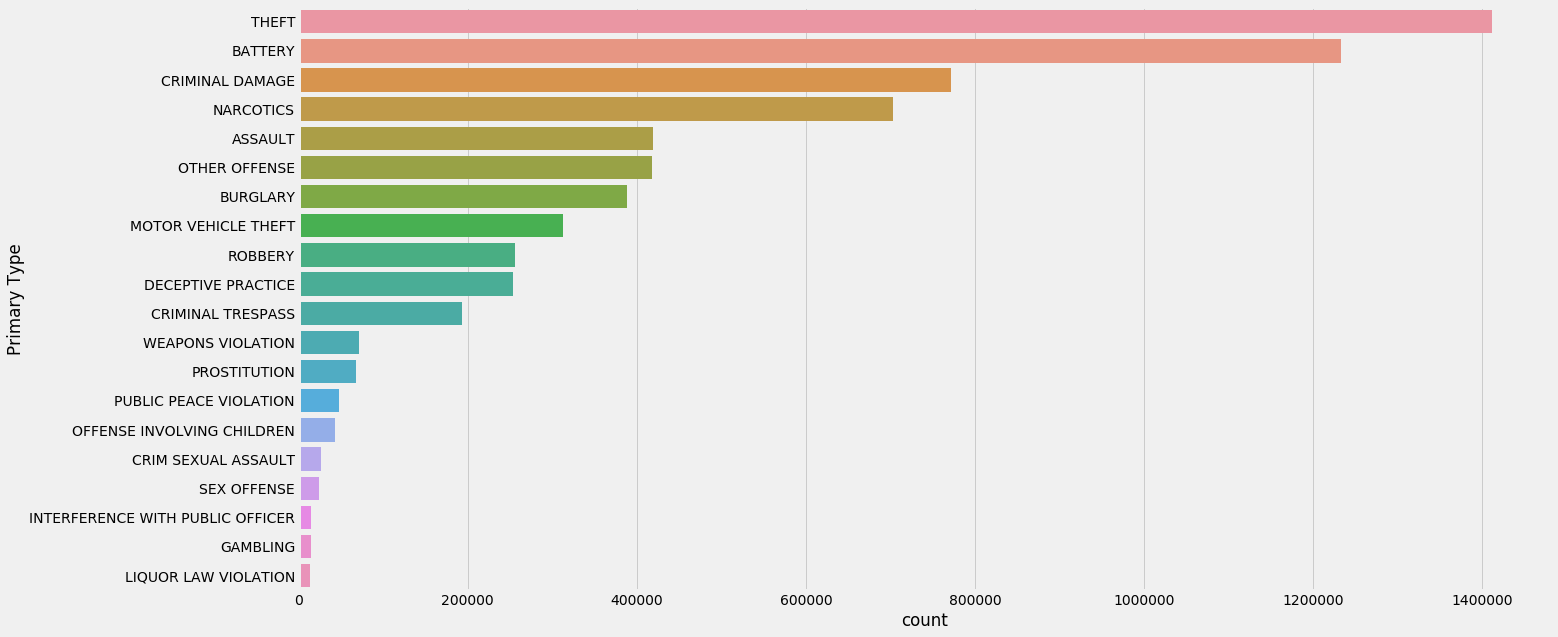

In [11]:
sns.countplot(y='Primary Type', data=chicago_cmr1, order=chicago_cmr1['Primary Type'].value_counts().iloc[:20].index)

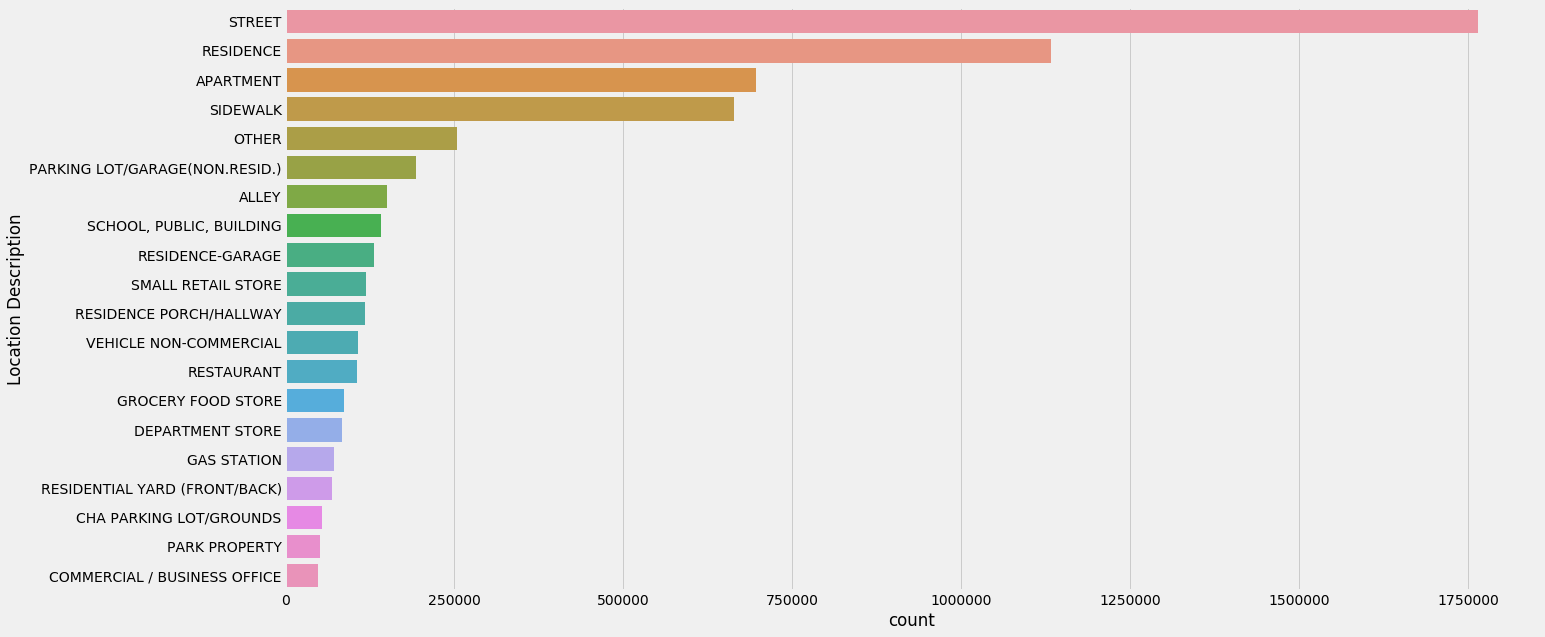

In [12]:
sns.countplot(y='Location Description', data=chicago_cmr1, order=chicago_cmr1['Location Description'].value_counts().iloc[:20].index)

### Since now we now which are the most commited crimes and where, let's check which is the type of crime that most often leads to an arrest.

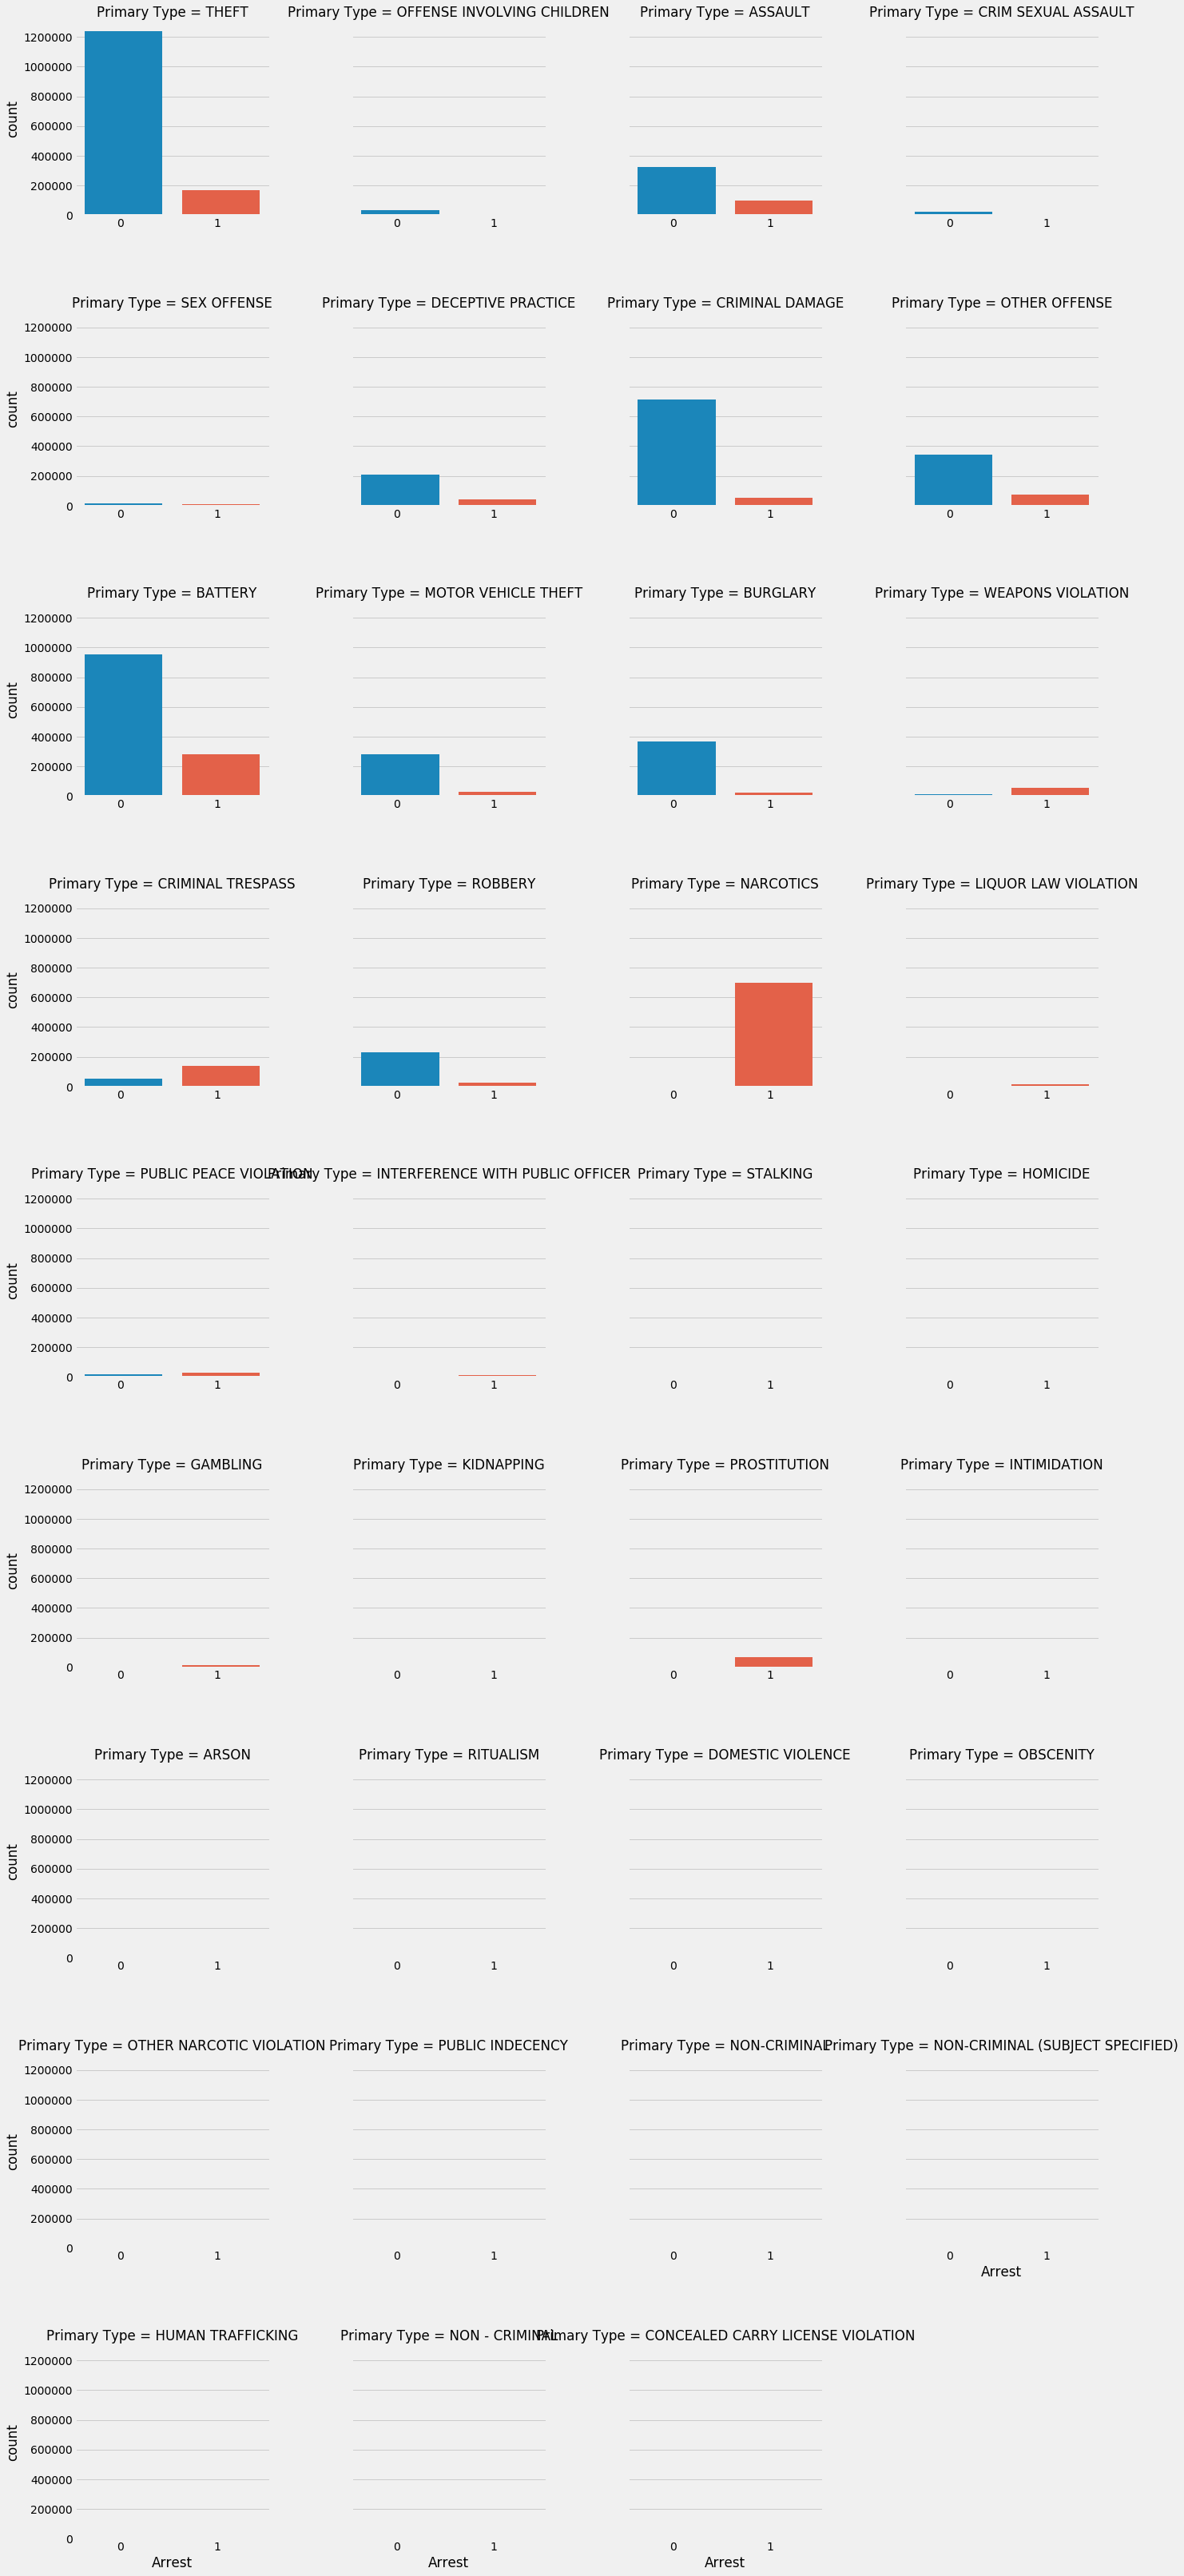

In [13]:
arrest_primaryT =sns.catplot(x="Arrest", col="Primary Type", col_wrap=4, data=chicago_cmr1, kind="count")

# Setting visual aspects of FacetGrid
set_xticklabels(arrest_primaryT)

### We can see that Narcotics stands out from the rest of the types. Most of the Narcotics crimes end up in arrest.

### Now we're going to set the date as index, that way we plot the evolution in time of the different type of crimes. 

In [35]:
chicago_cmr1.index = pd.DatetimeIndex(chicago_cmr1['Date'])

In [36]:
crimes_per_district = chicago_cmr1.pivot_table(values='Date', aggfunc=np.size, columns='Primary Type', index=chicago_cmr1.index.date, fill_value=0)


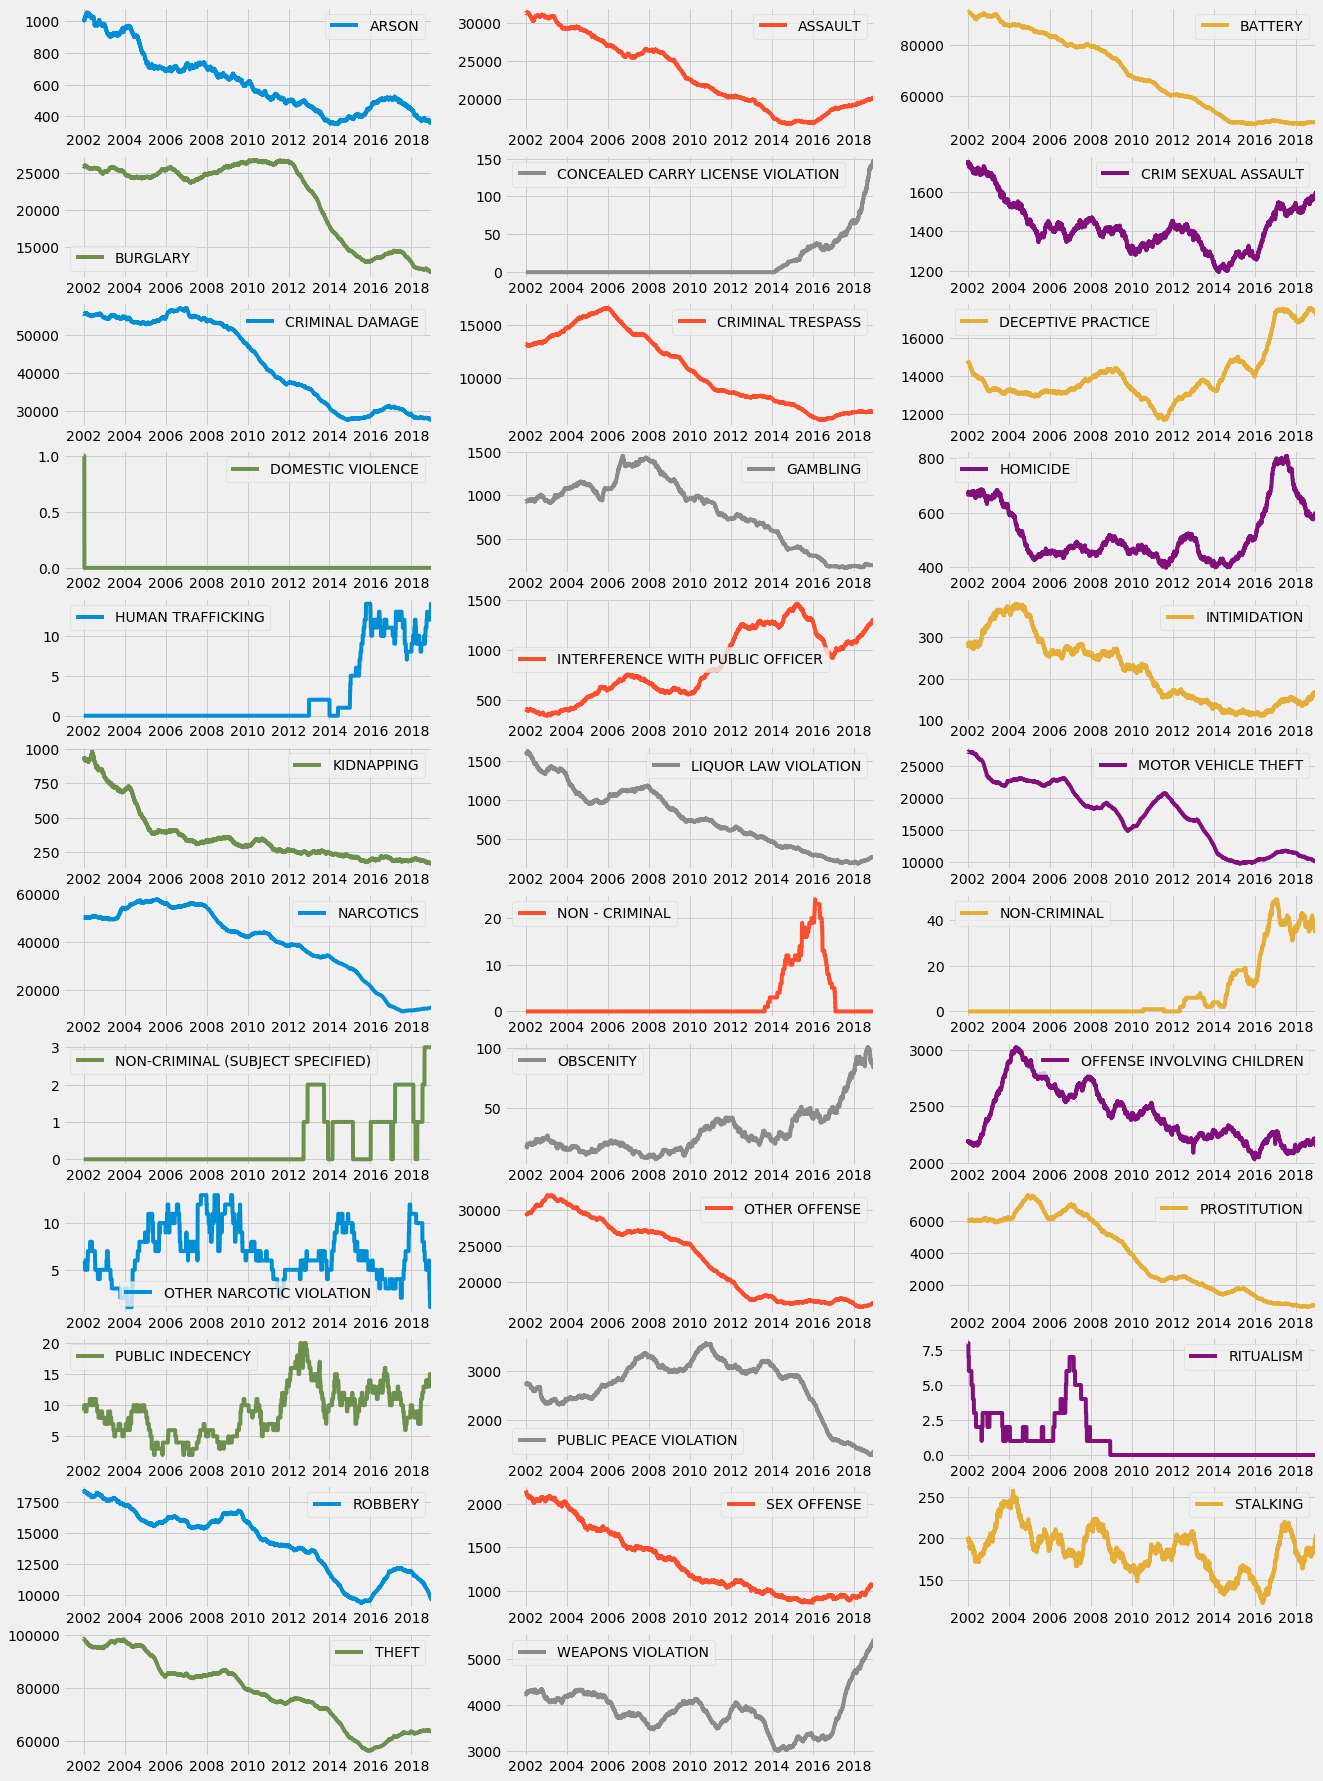

In [38]:
crimes_per_district.index = pd.DatetimeIndex(crimes_per_district.index)
plo = crimes_per_district.rolling(365).sum().plot(figsize=(20, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

### It's curious that the normal trend for the majority of types is descending, but some of them, like Homicides, have a sudden spike. Let's explore this variable in detail.

In [28]:
plt.figure(figsize=(20, 10))
crimes_per_district = pd.DataFrame(crimes_per_district['HOMICIDE'].rolling(365).sum().reset_index())

<Figure size 1440x720 with 0 Axes>

In [29]:
crimes_per_district = crimes_per_district.rename(columns={'index': 'Date'})

In [30]:
crimes_per_district.iplot(kind='line', x='Date', xTitle='Year/Month',
          color='green', yTitle='Total Number of Homicides', title='Number of Homicides by Month/Year')